# Optimization of a circulator layout

Author: Alexis Morvan
Date: 2021-06-02

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")

from freq_allocation.yield_mc_simulation import *
from freq_allocation.frequency_graph import FrequencyGraph
from freq_allocation.optimization import layout_optimizer

# silencing pyomo wanring
import logging

logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# import pandas as pd

## Definition of the layout
We are defining a circular layout of N-transmons. Here we consider a simple circular layout where the edge goes likes:

0 --> 1 --> 2 --> ... --> N//2 <-- ... <-- N-1 <-- N <-- 0

### Ring parameters

In [12]:
# N = 8  # number of transmons
# edges = [(0, 1), (1, 2), (2, 3), (3, 4), (5, 4), (6, 5), (7, 6), (0, 7)]  # edges

N = 4
edges = [(k, k+1) for k in range(N//2)]
edges += [(k, k-1) for k in range(N//2+1, N)]
edges += [(0, N-1)]

architecture = "CR"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = False # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False
# solver name

In [13]:
edges

[(0, 1), (1, 2), (3, 2), (0, 3)]

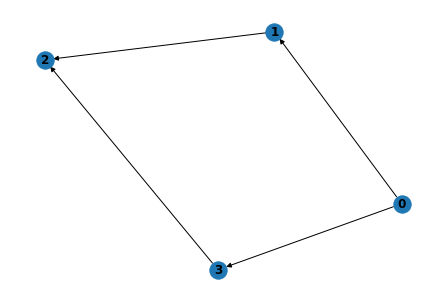

In [14]:
G = FrequencyGraph(edges=edges, cz=cz)
G.plot()

In [15]:
G.cz

False

In [16]:
#thresholds
if architecture == 'CR':
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "F1", "F2", "M1"]
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cr_keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4","C1", "C1b", "F1", "F2", "M1"]
    cstr_key = cr_keys

#CZ constraints
elif architecture == 'CZ':
    keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
    d = np.array([0.017, 0.03 , 0.03 , 0.017, 0.03 , 0.002, 0.017, 0.03 , 0.002, 0.017, 0.025, 0.017])
    d_dict = { k: dd for (k, dd) in zip(keys, d)}
    cstr_key = keys

# free of drive
# keys = ['A1', 'A2i', 'A2j', "E1", "E2", "E4", "E1t", "E2t", "E4t", "F1", "F2", "M1"]
# d = np.array([0.017, 0.03 , 0.03 , 0.00, 0.00 , 0.000, 0.00, 0.00 , 0.000, 0.00, 0.00, 0.00])
# d_dict = { k: dd for (k, dd) in zip(keys, d)}
# cstr_key = keys

## Optimization of the frequency

### optimization parameters

In [17]:
optimizer = layout_optimizer(graph=G,
                             architecture=architecture,
                             qutrit=qutrit,
                             all_differents=all_differents)

### Optimization

In [18]:
# perform the optimization
optimizer.declare_solver()
result = optimizer.first_pass()
optimizer.second_pass()
result = optimizer.third_pass()

### Adding the results to the frequencyGraph

In [19]:
# # manually adding the frequencyes and the drives
# freqs = np.array([ 5.63, 5.55, 5.40, 5.25, 5.05, 5.15, 5.3, 5.43])
# freqs = np.array([ 5.794, 5.659, 5.478, 5.297, 5.115, 5.240, 5.421, 5.603])
# freqs = {k: freqs[k] for k in range(8)}
# anharms = {k: -0.310 for k in range(8)}
# drives =  {e: freqs[e[1]] for e in G.edges}

In [20]:
# drives

In [21]:
freqs, anharms, drives = optimizer.get_solution()
G.set_values(freqs, anharms, drives)
print(G.check_solution(d_dict, cstr=cstr_key))

The edge (0, 1) is not a CR edge
True


[]

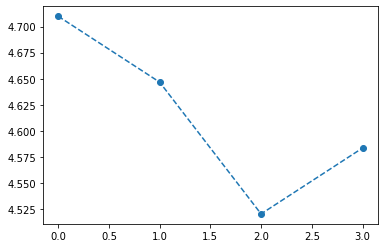

In [22]:
fig, ax = plt.subplots()
ax.plot(G.freqs, 'o--')
ax.plot()

## Yield of the design

Qubit collisions:
yield   = 0.2613
average = 2.01532


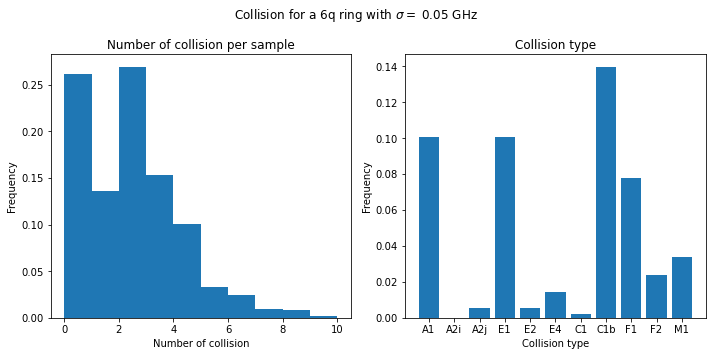

In [53]:
# parametrization
Nsamples = 50000
sigma = 0.05

# Calculating yield
collisions, c, idx_list, constraints = G.get_collision(d_dict, sigma=sigma, qutrit=False, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

### Collision type distribution

### Collision spatial distribution

In [54]:
x = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
xm = [(x[i] + x[i+1])/2 for i in range(len(x)-1)]

Text(0.5, 0, 'Collision type')

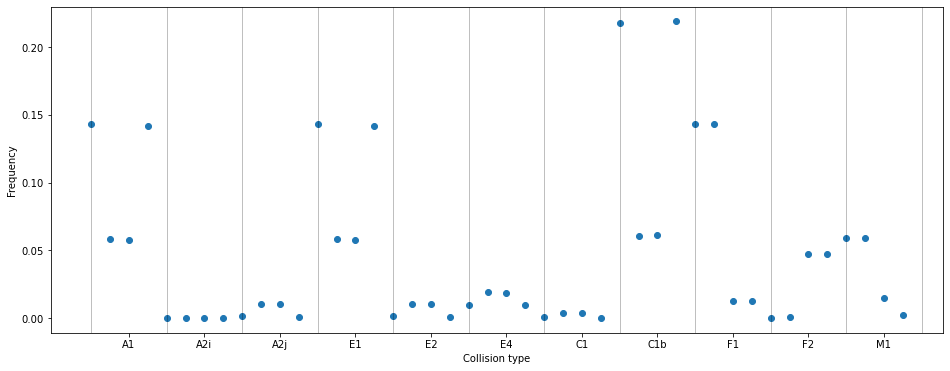

In [55]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(np.sum(~np.array(c), axis=1)/Nsamples, 'o')
for xx in x:
    ax.axvline(xx, color='k', linewidth=0.5, alpha = 0.5)
ax.set_xticks(xm);
ax.set_xticklabels(constraints)

ax.set_ylabel('Frequency')
ax.set_xlabel("Collision type")

### Collision vs std of the frequencies

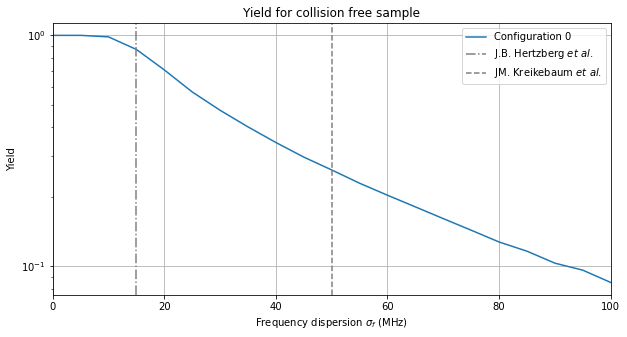

In [56]:

# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 50000

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.1, 21)

# saving the results
collisions = np.array([G.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

ax.set_xlim(0, 100)
ax.grid()

# Transfering to larger lattice

In [57]:
# scaling up:
N = 4*2
edges = [(0, 1), (1,2), (3,2), (4, 3), (4, 5), (5,6), (7,6), (0, 7)]

architecture = "CR"  # choosing the architecture: CZ or CR
cz = True if architecture=='CZ' else False
qutrit = False # qutrit or qubits

# for later:
# thresholds
# weights
all_differents = False


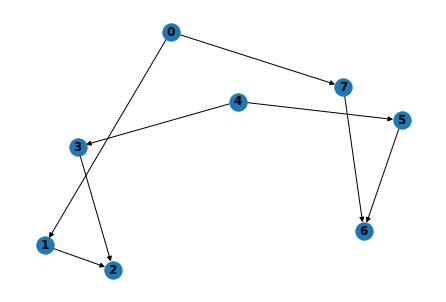

In [58]:
G2 = FrequencyGraph(edges=edges, cz=cz)
G2.plot()

In [85]:
# # manually adding the frequencyes and the drives 
freqs = {k: G.freqs[k] for k in range(4)}
anharms = {k: G.anharmonicity[k] for k in range(4)} 
drives =  {e: freqs[e[1]] for e in G.edges}

In [86]:
for k in range(4):
    freqs[k+4] = freqs[k]

In [87]:
for k in range(4):
    anharms[k+4] = anharms[k]

In [88]:
exceptional_edge = (0,3)

# add the new edges:
from copy import deepcopy
new_drives = deepcopy(drives)
for k in drives.keys():
    if k not in exceptional_edge:
        i, j = k
        new_drives[( (i+4)%8, (j+4)%8)] = drives[(i, j)]    
# change the 0 of the (0,3) edge
new_drives[(4,3)] = drives[(0, 3)]
new_drives[(0,7)] = drives[(0, 3)]
new_drives.pop((0,3), None)
new_drives.pop((4,7), None)

4.575

In [89]:
new_drives

{(0, 1): 4.63,
 (1, 2): 4.52,
 (3, 2): 4.52,
 (4, 5): 4.63,
 (5, 6): 4.52,
 (7, 6): 4.52,
 (4, 3): 4.575,
 (0, 7): 4.575}

In [93]:
drives

{(0, 1): 4.63, (0, 3): 4.575, (1, 2): 4.52, (3, 2): 4.52}

The drive frequency are CR compatible
True


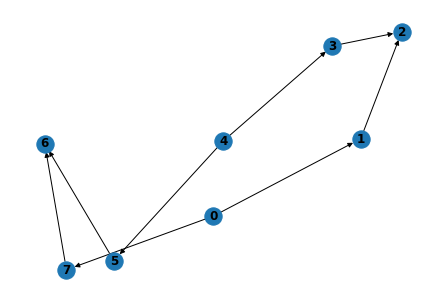

In [95]:
G2 = FrequencyGraph(edges=list(new_drives.keys()), cz=cz)
G2.plot()
G2.set_values(freqs, anharms, new_drives)
print(G2.check_solution(d_dict, cstr=cstr_key))

Qubit collisions:
yield   = 0.06132
average = 4.01872


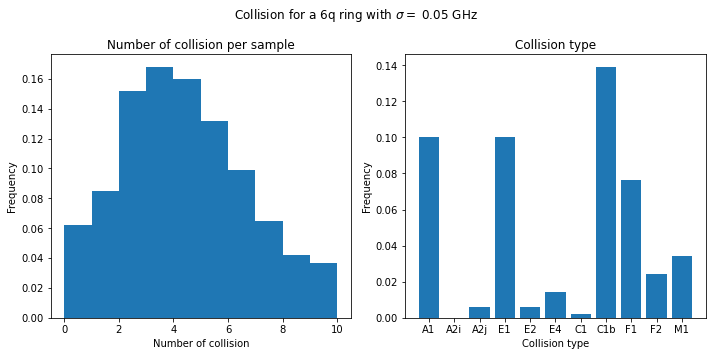

In [96]:
# parametrization
Nsamples = 50000
sigma = 0.05

# Calculating yield
collisions, c, idx_list, constraints = G2.get_collision(d_dict, sigma=sigma, qutrit=False, cstr=cstr_key, Nsamples=Nsamples)

idx_len = [len(idx) for idx in idx_list]
cstr_list = []
for ct, ilen in zip(constraints, idx_len):
    cstr_list += [ct]*ilen 

print("Qubit collisions:")
print(f"yield   = {np.sum(collisions==0)/len(collisions)}")
print(f"average = {np.sum(collisions)/len(collisions)}")


###### plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

## plot of the yield
ax = axs[0]
ax.hist(collisions, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)

#legend
ax.set_xlabel("Number of collision")
ax.set_ylabel("Frequency")
ax.set_title("Number of collision per sample")

## histogram of the type of errors
ax = axs[1]
c = np.array(c)
cc = np.sum(~np.array(c), axis=1)
v = [sum(idx_len[:k]) for k in range(len(idx_len)+1)]
col = np.array([np.mean(cc[v[i]: v[i+1]]) for i in range(len(v)-1)])/Nsamples

ax.bar(np.arange(len(col)), col)
ax.set_xticks(np.arange(len(col)))
ax.set_xticklabels(cstr_key)

# legend and labels
ax.set_xlabel('Collision type')
ax.set_ylabel('Frequency')
ax.set_title("Collision type")
fig.suptitle(f"Collision for a 6q ring with $\sigma=$ {sigma} GHz")

fig.tight_layout()

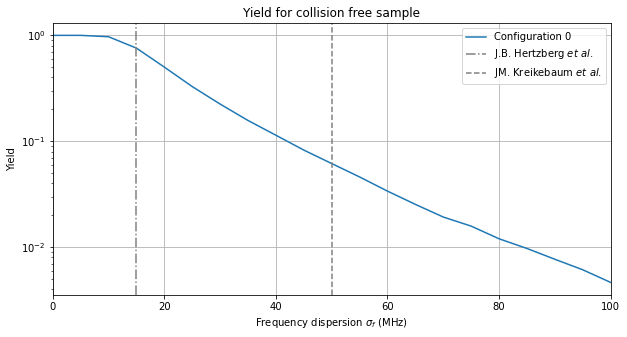

In [102]:
# initialization the plot
fig, ax = plt.subplots( figsize=(10, 5))

# N_samples
Nsamples = 100000

# varying the dispersion of the frequency
s_vec = np.linspace(0, 0.1, 21)

# saving the results
collisions = np.array([G2.get_collision(d_dict, Nsamples=Nsamples, sigma=s, cstr=cstr_key)[0] for s in s_vec])

n_collisions = [0]
y = [(Nsamples-np.count_nonzero(collisions-n, axis=1))/Nsamples for n in n_collisions]

ax.plot(s_vec*1e3, y[0], label=f'Configuration {0}')


ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=10, loc=0)

ax.set_xlim(0, 100)
ax.grid()

In [103]:
data = {"sigma": s_vec, 
        "collisions": collisions,
        "key": cstr_key,
        "yield": y,
        "samples":Nsamples}
np.save(f'ring_8t_{architecture}_yield_2x4.npy',data)

In [104]:
data_CR = np.load('ring_8t_CR_yield.npy', allow_pickle=True)[()]

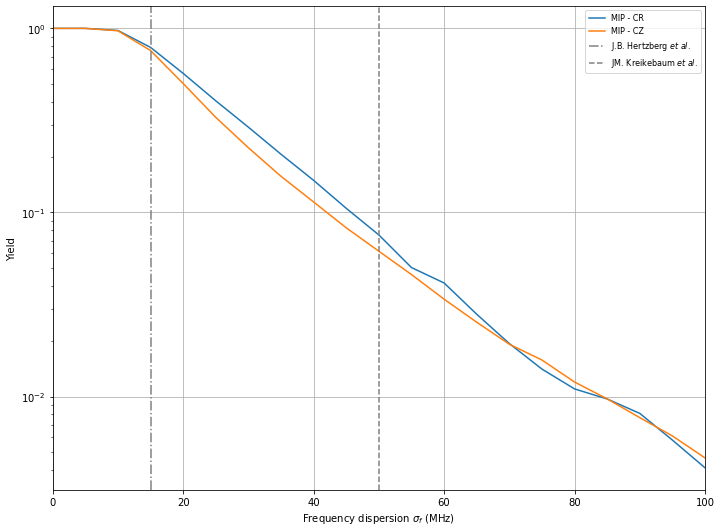

In [105]:
fig, ax = plt.subplots(figsize=(3*3.375, 3*2.5))


s_vec_cr = data_CR["sigma"]
y_cr = data_CR["yield"]

s_vec_cz = data["sigma"]
y_cz = data["yield"]



ax.plot(s_vec_cr*1e3, y_cr[0], label=f'MIP - CR')
ax.plot(s_vec_cz*1e3, y_cz[0], label=f'MIP - CZ')

ax.axvline(15, ls='-.', color='Gray', label = r"J.B. Hertzberg $\it{et~al.}$")
ax.axvline(50, ls='--', color='Gray', label = r"JM. Kreikebaum $\it{et~al.}$")

# Legend and labels
ax.set_ylabel(f'Yield')
ax.set_xlabel('Frequency dispersion $\sigma_f$ (MHz)')
ax.set_yscale('log')
# ax.set_title('Yield for collision free sample')
ax.legend(ncol=1, fontsize=8, loc=0)

ax.set_xlim(0, 100)
ax.grid()

fig.tight_layout()

# fig.savefig("fig_yield_ring.pdf")